<a href="https://colab.research.google.com/github/andrew-veriga/MathForML/blob/master/ConvolutionalCoffieCircles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libs

In [0]:
import tensorflow as tf
import numpy as np

### Load picture

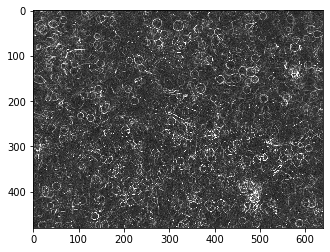

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path='https://github.com/andrew-veriga/MathForML/blob/master/CoffieCircles.png?raw=true'
Image = mpimg.imread(img_path)
plt.imshow(Image)

In [23]:
print(Image.shape)

(480, 640, 4)


###Prepare picture
Convert Image to 2D

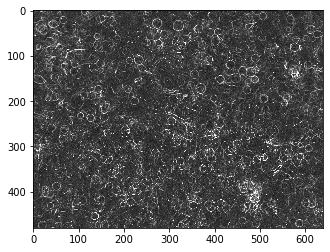

In [24]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Image = rgb2gray(Image)    
plt.imshow(Image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [25]:
print (Image.shape)

(480, 640)


###Init variables

`MaxSize` - max size of square region

`MinSize` - min size of square region

`Contrast` - scalar set contrast of recognizing ring 
`Thick` - thickness of ring
`FoundCircles` - numpy array of centers and radiuces (3,None)

In [0]:
firstX=1
firstY=1
ImageSize = (48,90) #Image.shape
MaxSize = 40 
MinSize = 10
Contrast = 2.
Variance = 0.03
Thick = .8
FoundCircles = np.array([0,3])
_DEBUG_=False

In [0]:
# from scipy.spatial import distance
# for i in range(0,a.shape[0]):
#   d = [np.sum((a[i]-a[j])**2) for j in range(i+1,a.shape[0])] 
#   print(d) 

###function isCircleFound
calculate average brightness over all pixels of current square;
If pixels of SelectedRing have avg brightness more then avg brightness over all square - circle is found 


In [0]:
#from scipy.special import softmax

def isCircleFound(_box, _mask, _backmask):
  background = np.logical_xor(_backmask, _mask)  
  brightness = (lambda arr: np.percentile(arr-np.min(_box),90))#/(np.max(arr)-np.min(box))))
  if _DEBUG_:

    print ('ring brightness', brightness(_box[_mask]))
    print ('back brightness', brightness(_box[background]))
    print('ring.var', np.var(_box[_mask]))
    print('full.var', np.var(_box))
    print('back.var', np.var(_box[background]))
  return ((brightness(_box[_mask]) / brightness(_box[background])) > Contrast) #and np.var(_box[_mask])/np.var(_box[~_mask]) < 1)
  

###function getMask
create square matrix of boolean as a ring of Trues inscribed in a square of Falses

ring brightness 0.47642296492829916
back brightness 0.46073825998082757
ring.var 0.030505674829469295
full.var 0.019979368829408543
back.var 0.028097096951158633
False


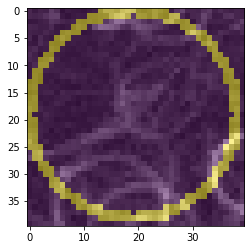

In [35]:
import itertools

def getMask( size, thick = 1 ):
    radius = size /2 - 1
    center = np.array([size/2-1,size/2-1])
    vectors = [[(i,j) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: np.abs(np.linalg.norm(v - center) - radius) < thick,l)))
    # print(selectedVecs)
    #ring mask
    ring = np.array(np.zeros((size,size),dtype=np.bool))
    
    for (i,j) in (selectedVecs):
      ring[i,j]=True
    
    return ring

square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
Mask=getMask(MaxSize,1) 
backMask=getMask(MaxSize,2) 
#ring visualisation
fig, ax = plt.subplots()
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax.imshow(Mask,alpha=.5)
fig.show()
_DEBUG_=True
print (isCircleFound(square, Mask, backMask))
_DEBUG_=False

### function FuzzyCircleConv

In [0]:
import numpy.ma as ma

def FuzzyCircleConv(_box, _mask):
  # return sum(np.dot(_box,_mask))
  mlt = np.multiply(_box,_mask)
  return np.sum(mlt)#/ np.var(ma.masked_values(mlt, 0.0 ))
  

###function getKernel

In [0]:
import itertools
import numpy as np
import random as rn
    # size=40 
    # thick = 1
MaxPix = np.max(Image)
MinPix = np.min(Image)

def getKernel( size, thick = 1. ):
    radius = size //2-1
    center = np.array([size/2-.5,size/2-.5])
    vectors = [[(i,j, thick - np.abs(np.linalg.norm((i,j) - center) - radius)) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: v[2] > 0. ,l)))
    #ring mask
    ring = np.ones((size,size), dtype=np.float32) #np.random.rand(size,size)
    # print(selectedVecs.T[2])
    # print(np.max(selectedVecs.T[2]))
    maxMask= np.max(selectedVecs.T[2])
    ring = -(ring - MinPix)/(MaxPix-MinPix)
    
    for (i,j,k) in (selectedVecs):
      ring[np.int(i),np.int(j)]=k/maxMask

    return ring
plt.imshow(getKernel(40,2),cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)


###One example of arbitrary ring

In [0]:
Mask = getKernel( MaxSize, 1 )
square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
    
#ring visualisation
#ring visualisation
fig, ax = plt.subplots(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)

ax1=fig.add_subplot(1,2,2)

ax1.imshow(np.multiply(square,Mask), cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
fig.show()
print('Conv value:',FuzzyCircleConv(square,Mask)/MaxSize**2)


###Some examples of founded ring

ring brightness 0.28585376256734163
back brightness 0.333299995033443
ring.var 0.01381369311673209
full.var 0.01527353533569725
back.var 0.020138940177579147
founded False
ring brightness 0.458777671862394
back brightness 0.27605082942500714
ring.var 0.03445835242705576
full.var 0.01931740580134702
back.var 0.024182420145722413
founded False
ring brightness 0.7022827161718905
back brightness 0.3215364737726748
ring.var 0.03810575812450433
full.var 0.024692104453684065
back.var 0.008599026778197825
founded True
ring brightness 0.5619046068920195
back brightness 0.2901670638777315
ring.var 0.015598000734567005
full.var 0.024111738472054556
back.var 0.018273543843990287
founded True
ring brightness 0.6442493004164099
back brightness 0.3701590516600011
ring.var 0.029809041137015244
full.var 0.03757995335955344
back.var 0.01844904230270638
founded False
ring brightness 0.5717075474841895
back brightness 0.3133020036752521
ring.var 0.02982311053022883
full.var 0.027093995305186296
back.var 0

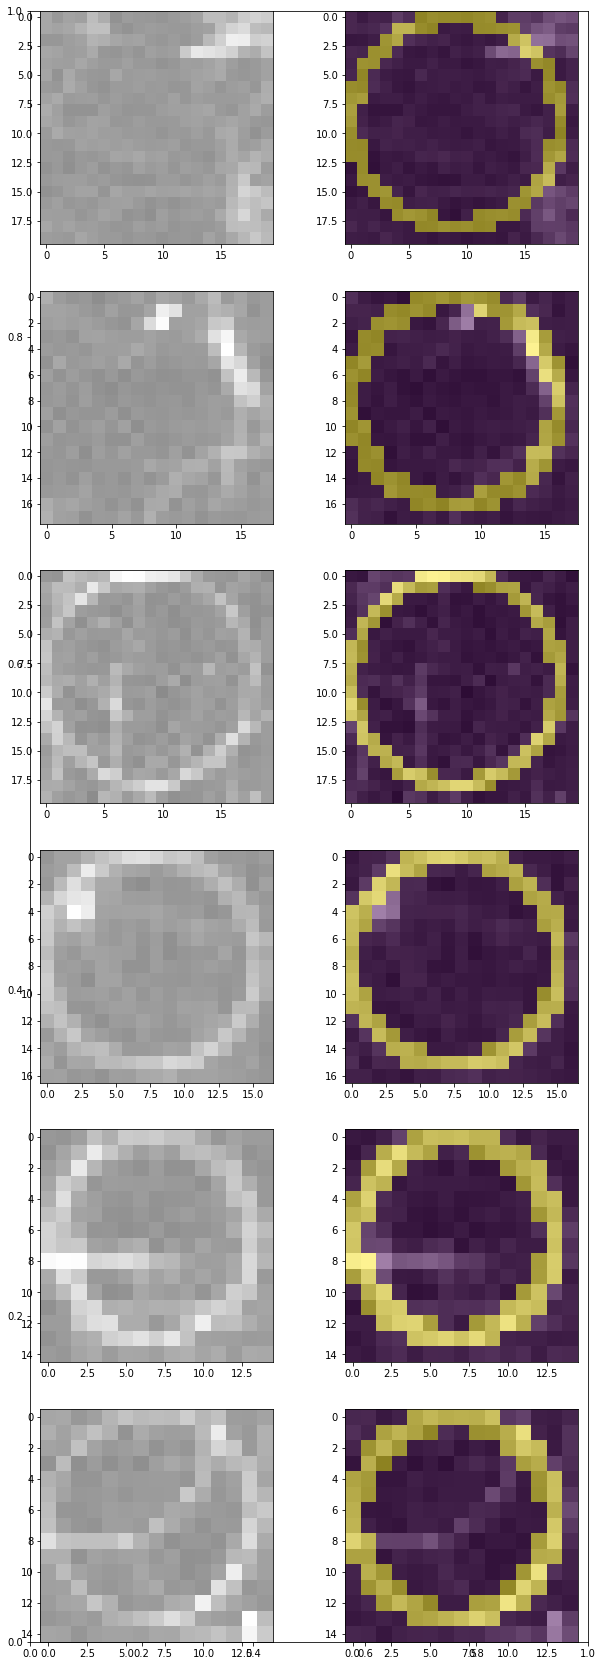

In [46]:
Contrast = 1.8
Variance = 0.03
# data array of some square size, x and y
# the first of data is nothing but all other are founder rings
data=np.array([
      [20,1,1],
      [18,168,44],
      [20,148, 227],
      [17, 59, 14],
      [15, 134, 51],
      [15, 139, 77]
      ])
# x=58
# y=13
# size=18
# x1=133
# y1=50
# size1=16
len = data.shape[0]
fig, ax = plt.subplots(figsize=(10,5*len))
i=1
for size,x,y in data:
  Mask = getMask( size, 0.8 )
  square = Image[y:y+size, x:x+size]
  #ring visualisation
  ax = fig.add_subplot(len,2,i)
  ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)    
  ax1=fig.add_subplot(len,2,i+1)
  ax1.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
  ax1.imshow(Mask,alpha=.5)
  _DEBUG_=True
  # print('conv value', FuzzyCircleConv(Mask,square)/size**2)
  print('founded', isCircleFound(square,Mask,getMask(size,2)))
  i+=2

fig.show()

_DEBUG_=False
# 1.060025172295898
# 1.7058462602826763
# 2.507759339776636
# 2.07602457443179
# 1.6815561885414665

In [74]:
data.shape
len

3

###Try classic convolutions

conv value -0.12937657019172136
-0.12937657019172139


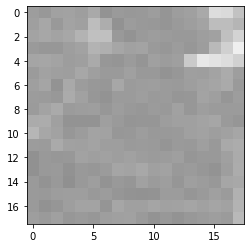

In [14]:
  
  SquareSize=18
  Thick=1
  kernel=getKernel( SquareSize, Thick )
  kernel_size =kernel.shape[0]
  pad_size = kernel_size // 2
  rest = kernel_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.zeros((pad_size, ImageSize[1]+pad_size*2), dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = kernel.shape
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)
  #arbirtary region
  square = sub_matrices[pad_size,pad_size,:,:]
  plt.imshow(square,plt.get_cmap('gray'), vmin=-1, vmax=1)
  print('conv value', FuzzyCircleConv(square,kernel)/kernel_size**2)
  m=np.sum(np.multiply(sub_matrices,kernel), axis=(2,3))/(kernel_size**2)
  # m = np.sum(np.multiply(square))/(kernel_size**2)
  print(m[pad_size,pad_size])  

In [15]:
sub_matrices.shape

(48, 90, 18, 18)

conv value -0.08034258328586487
-0.08034258328586488


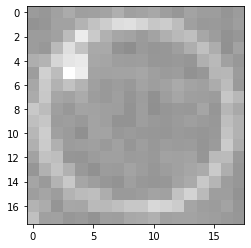

In [16]:
#founded ring
square = sub_matrices[pad_size+13,pad_size+58,:,:]
plt.imshow(square,plt.get_cmap('gray'), vmin=-1, vmax=1)
print('conv value', FuzzyCircleConv(square,kernel)/kernel_size**2)
m=np.sum(np.multiply(sub_matrices,kernel), axis=(2,3))/(kernel_size**2)

print(m[pad_size+13,pad_size+58])

In [17]:
sub_matrices.shape


(48, 90, 18, 18)

In [0]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
def conv(_kernel):
  # _kernel = getKernel( size, Thick )
  kernel_size = _kernel.shape[0]
  pad_size = kernel_size // 2
  rest = 0#kernel_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.random.rand(pad_size, ImageSize[1]+pad_size*2)#, dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = (_kernel.shape)
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)


  # m=np.sum(np.multiply(sub_matrices,_kernel), axis=(2,3))/(kernel_size**2)
  m = np.einsum('ij,klij->kl',_kernel,sub_matrices)/kernel_size**2
  return m
  

### try masqueraded convolutions

In [0]:
ImageSize=Image.shape

In [0]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
def mask_conv(_mask,_backmask):
  # size=16
  # (_mask,_backmask)=(getMask( size, .8 ),getMask( size, 2 ))
  mask_size = _mask.shape[0]
  pad_size = mask_size // 2
  rest = 0#mask_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.random.rand(pad_size, ImageSize[1]+pad_size*2)#, dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = (_mask.shape)
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)
  
  background = np.logical_xor(_backmask, _mask)  
  
  nrm = np.min(sub_matrices,axis=(2,3))
  brightness = (lambda arr, msk: np.percentile(arr[:,:,msk],90,axis=2)-nrm)#/(np.max(arr)-np.min(box))))
  m = brightness(sub_matrices,_mask) / brightness(sub_matrices,background)
  # m = np.logical_and(np.greater((brightness(sub_matrices,_mask) - brightness(sub_matrices,~_mask)),Contrast), np.less(np.var(sub_matrices[:,:,_mask],axis=2), Variance)) #/ np.var(sub_matrices,axis=(2,3)) # > Contrast #and np.var(_box[_mask]) < Variance):
  

  # m=np.sum(np.multiply(sub_matrices,_mask), axis=(2,3))/(mask_size**2)
  # m = np.einsum('ij,klij->kl',_mask,sub_matrices)/mask_size**2
  return m
  

### Main loops


In [0]:
MinSize=16
ConvMatrices = np.empty((0,ImageSize[0],ImageSize[1]))
for size in range(MinSize,MaxSize):
  #print('size '+str(size))
  res = mask_conv(getMask( size, .8 ),getMask( size, 2 ))
  ConvMatrices= np.concatenate((ConvMatrices, np.reshape(res,(1,ImageSize[0],ImageSize[1]))),axis=0)

In [42]:
for size,x,y in data:
  print(ConvMatrices[size-MinSize,y+size//2,x+size//2])    


1.060025172295898
1.7058462602826763
2.507759339776636
2.07602457443179
1.6815561885414665


In [32]:
print(ConvMatrices.shape)

(22, 480, 640)


In [0]:
# outfile = TemporaryFile()
np.save('ConvMatrices', ConvMatrices)

size:  16
size:  17


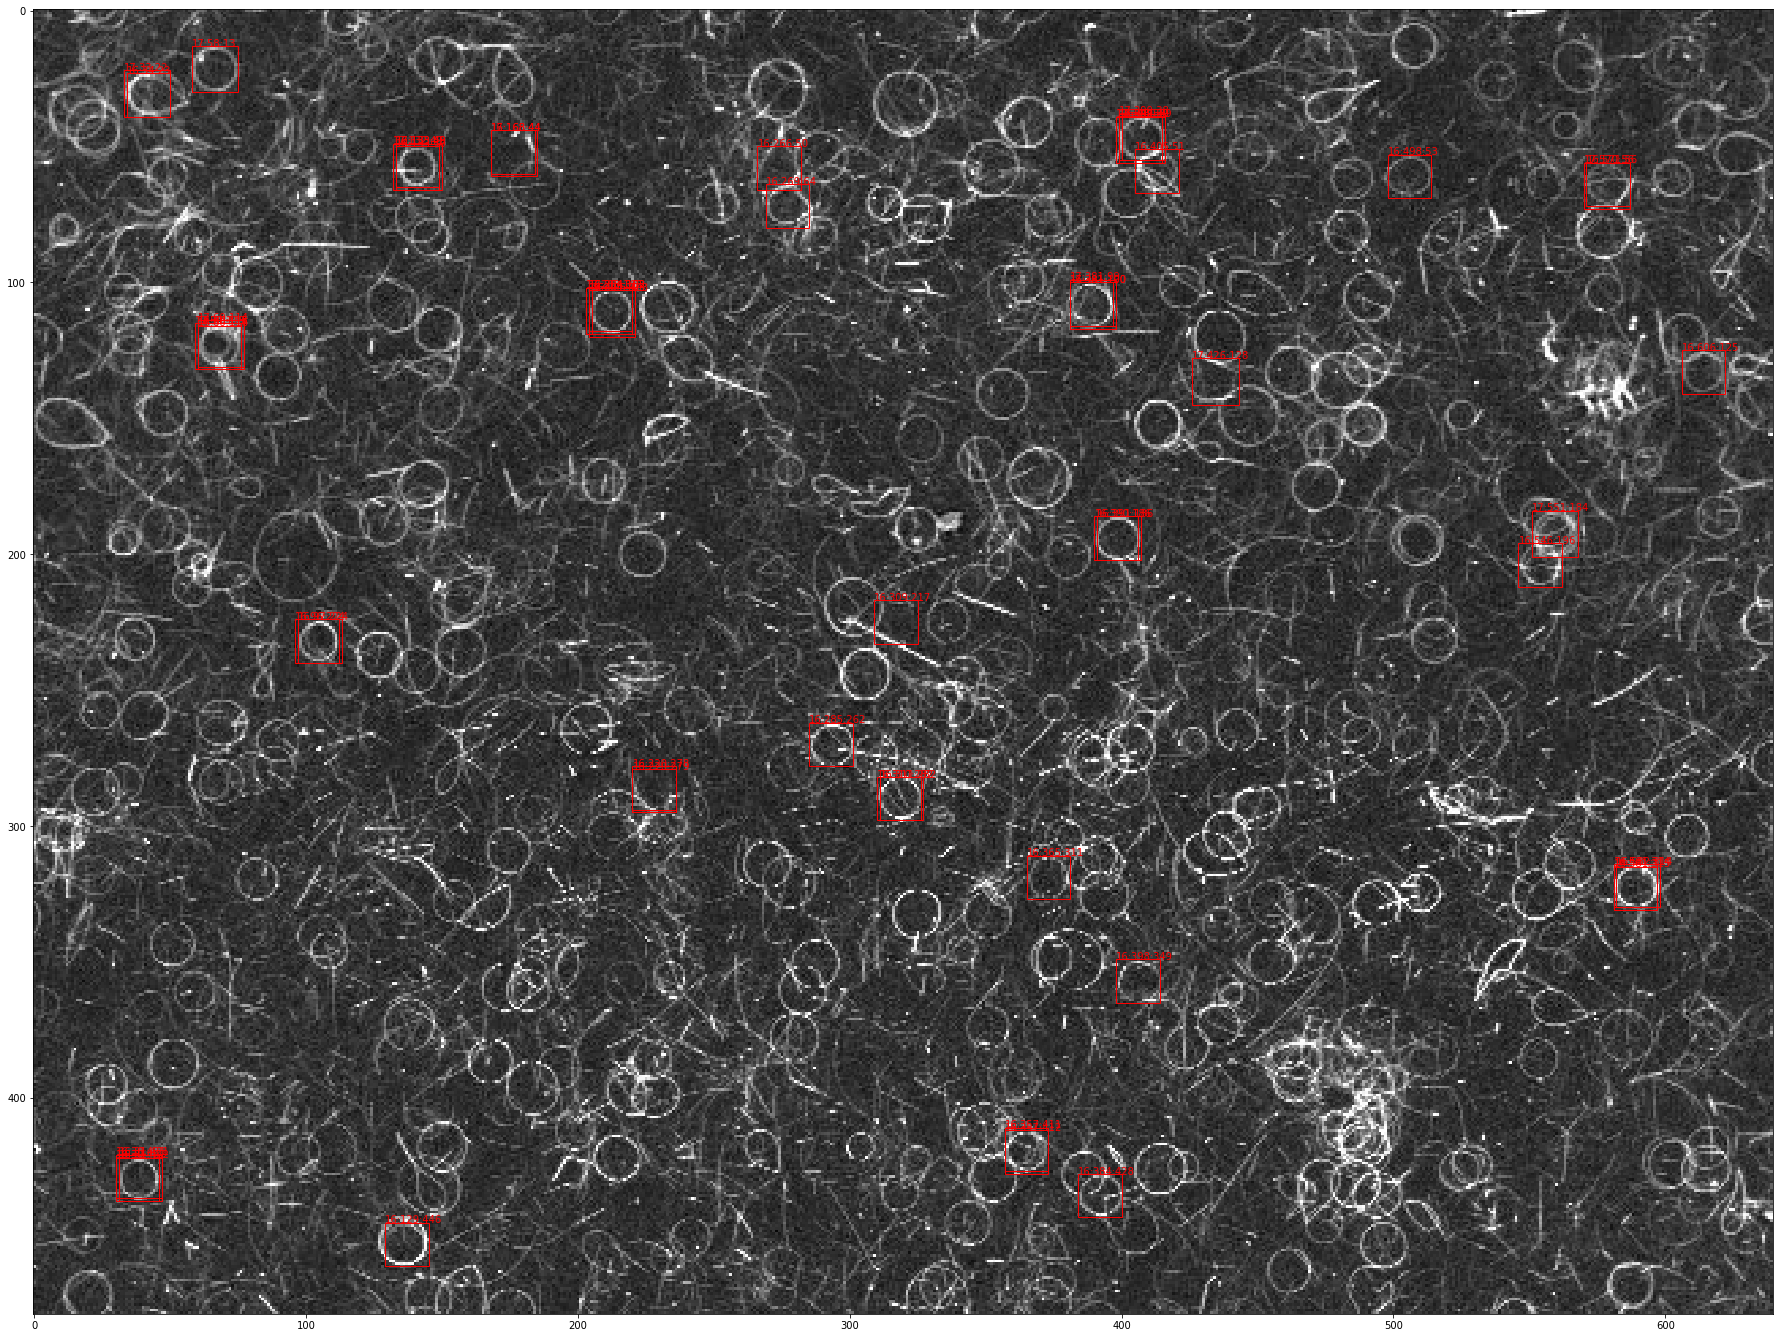

In [44]:
Contrast=0.17
import matplotlib.patches as patches
# plt.ioff()
fig, ax = plt.subplots(figsize=(32, 24))
ax.imshow(Image,cmap=plt.get_cmap('gray') )
# Create a Rectangle patch

cnt=0
for size in range(MinSize,MaxSize):
  print('size: ',size)
  convs = ConvMatrices[size-MinSize,size//2:-size//2,size//2:-size//2]
  for i in range(size//2,convs.shape[0]-size//2):
    y= i 
    for j in range(size//2, convs.shape[1]-size//2):
      x = j 
      if (convs[i,j]>2.):
        rect = patches.Rectangle((x,y),size,size,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        lbl = str(size)+':'+str(x)+':'+str(y)
        ax.text(x,y, lbl,
          color='red')
        # plt.text(x,y,lbl,facecolor='r')
        #print(x, y, convs[i,j])
        cnt+=1
      if (cnt>60):
        break
    else:
      continue
    break
  else:
    continue
  break

plt.show()